# Waifu face generation

## Dataset

First download the data from a GoogleDrive folder.

In [1]:
# import urllib.request
# from pathlib import Path
# import zipfile
# tmp_filename = "archive.zip"
# Path("./data").mkdir(exist_ok=True)
# urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1R-8ieidrUVuqNHgD-Hyw_od5pHbjgbOO&confirm=t&uuid=25b26a1a-8ed1-4eb1-a2a4-343d0e48a3ee&at=ALgDtswyiievmv0tddNky9ePQCt9:1676728294393", tmp_filename);
# with zipfile.ZipFile(tmp_filename, 'r') as zip_ref:
#     zip_ref.extractall("./data")
# Path(tmp_filename).unlink()

In [2]:
#@title Train/validation split
import os
import shutil
import numpy as np

# seed = 0
# np.random.seed(seed)
# print(f'Numpy random seed: {seed}.')

# val_split = 0.2

# files = os.listdir("./data/images/")
# np.random.shuffle(files)

# split_index = int(len(files) * val_split)
# files_val, files_train = files[:split_index], files[split_index:]

# for dir in ['val', 'train']:
#   try:
#     os.mkdir(f"./data/{dir}/")
#   except FileExistsError:
#     pass

# for file in files_val:
#   source = os.path.join("./data/images/", file)
#   destination = os.path.join("./data/val/", file)
#   shutil.move(source, destination)

# for file in files_train:
#   source = os.path.join("./data/images/", file)
#   destination = os.path.join("./data/train/", file)
#   shutil.move(source, destination)

# os.rmdir("./data/images/")  # delete images folder

In [3]:
#@title Imports
from __future__ import print_function
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

seed = 0
torch.manual_seed(seed)
print(f'Torch random seed: {seed}.')

Torch random seed: 0.


In [4]:
#@title Model and training parameters
training_path = "./data/train/"
validation_path = "./data/val/"

batch_size = 128
image_size = 64
channels = 3

latent_size = 100
g_features = 64
d_features = 64

epochs = 25
lr = 2e-4
beta1 = 0.5

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
#@title Dataset class and transforms
training_transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

val_transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
])


class ImageSet(Dataset):
    def __init__(self, path, transform, preload=False):
        self.path = path
        self.files = os.listdir(self.path)
        self.transform = transform
        self.preload = preload
        if self.preload:
          self.files = [
              self.transform(
                  Image.open(os.path.join(self.path, file))
              ) for file in self.files]

    def __getitem__(self, index):
        if self.preload:
          return self.files[index]
        else:
          return self.transform(
              Image.open(os.path.join(self.path, self.files[index]))
          )
    
    def __len__(self):
        return len(self.files)

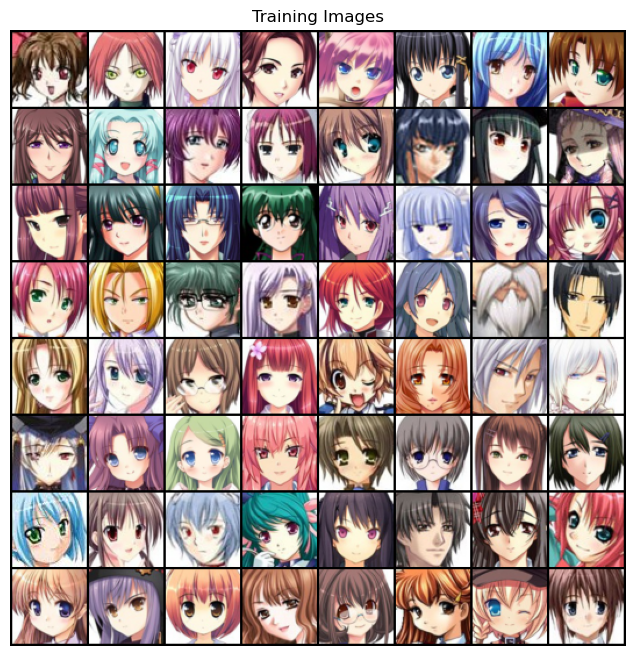

In [6]:
#@title Datasets making
training_set = ImageSet(
    path=training_path,
    transform=training_transform,
    preload=True,
)
validation_set = ImageSet(
    path=validation_path,
    transform=val_transform,
    preload=False,
)

training_loader = DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = DataLoader(
    validation_set,
    batch_size=1,
    shuffle=False
)

# Plot some training images
batch = next(iter(training_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [7]:
#@title Model architecture
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, channels, latent, features):
        super(Generator, self).__init__()
        self.body = nn.Sequential(
            nn.ConvTranspose2d(latent, features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 8, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 4, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(features * 2, features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(True),

            nn.ConvTranspose2d(features, channels, 4, 2, 1, bias=False),
            nn.Tanh()
      )

    def forward(self, x):
        return self.body(x)


class Discriminator(nn.Module):
    def __init__(self, channels, features):
        super(Discriminator, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 4, features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.body(x)

In [8]:
generator = Generator(channels, latent_size, g_features).to(device)
generator.apply(weights_init)

discriminator = Discriminator(channels, d_features).to(device)
discriminator.apply(weights_init)

print(generator)
print()
print(discriminator)

Generator(
  (body): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
criterion = nn.BCELoss()

# convention
real_label = 1.
fake_label = 0.

optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [10]:
#@title Training loop
g_losses = []
d_losses = []
results = {
    "d_real_score": [],
    "d_fake_score": [],
    "d_fake_score_2": [],
    "loss_d": [0.],
    "loss_g": [0.],
}
steps = 0

Epoch 1 of 25.
Last epoch average discriminator loss: 0.0.
Last epoch average generator loss: 0.0.


100%|██████████| 398/398 [00:55<00:00,  7.11it/s]


Epoch 2 of 25.
Last epoch average discriminator loss: 0.7718476533992731.
Last epoch average generator loss: 8.323028118167091.


100%|██████████| 398/398 [00:51<00:00,  7.66it/s]


Epoch 3 of 25.
Last epoch average discriminator loss: 0.7365424213696964.
Last epoch average generator loss: 5.983343229221938.


100%|██████████| 398/398 [00:52<00:00,  7.64it/s]


Epoch 4 of 25.
Last epoch average discriminator loss: 0.642338351201472.
Last epoch average generator loss: 5.839138372459603.


100%|██████████| 398/398 [00:51<00:00,  7.67it/s]


Epoch 5 of 25.
Last epoch average discriminator loss: 0.5395202797336794.
Last epoch average generator loss: 5.880485190219017.


100%|██████████| 398/398 [00:51<00:00,  7.66it/s]


Epoch 6 of 25.
Last epoch average discriminator loss: 0.44945299606676675.
Last epoch average generator loss: 5.880547175605093.


100%|██████████| 398/398 [00:39<00:00, 10.08it/s]


Epoch 7 of 25.
Last epoch average discriminator loss: 0.43506355370259164.
Last epoch average generator loss: 6.019542807610191.


100%|██████████| 398/398 [00:31<00:00, 12.56it/s]


Epoch 8 of 25.
Last epoch average discriminator loss: 0.4727143882282415.
Last epoch average generator loss: 5.680013243558269.


100%|██████████| 398/398 [00:31<00:00, 12.46it/s]


Epoch 9 of 25.
Last epoch average discriminator loss: 0.47860303088723116.
Last epoch average generator loss: 5.349343427611355.


100%|██████████| 398/398 [00:32<00:00, 12.43it/s]


Epoch 10 of 25.
Last epoch average discriminator loss: 0.4846343837079391.
Last epoch average generator loss: 5.132620397225097.


100%|██████████| 398/398 [00:32<00:00, 12.41it/s]


Epoch 11 of 25.
Last epoch average discriminator loss: 0.5210870140274266.
Last epoch average generator loss: 4.957410330374037.


100%|██████████| 398/398 [00:32<00:00, 12.35it/s]


Epoch 12 of 25.
Last epoch average discriminator loss: 0.4980342524247852.
Last epoch average generator loss: 4.786989017946636.


100%|██████████| 398/398 [00:32<00:00, 12.30it/s]


Epoch 13 of 25.
Last epoch average discriminator loss: 0.5271464707938271.
Last epoch average generator loss: 4.489705899702245.


100%|██████████| 398/398 [00:32<00:00, 12.26it/s]


Epoch 14 of 25.
Last epoch average discriminator loss: 0.5064152653642635.
Last epoch average generator loss: 4.203564009324989.


100%|██████████| 398/398 [00:32<00:00, 12.13it/s]


Epoch 15 of 25.
Last epoch average discriminator loss: 0.5291599858196536.
Last epoch average generator loss: 4.178218904377228.


100%|██████████| 398/398 [00:32<00:00, 12.18it/s]


Epoch 16 of 25.
Last epoch average discriminator loss: 0.4968831590072593.
Last epoch average generator loss: 3.9500836199851492.


100%|██████████| 398/398 [00:32<00:00, 12.18it/s]


Epoch 17 of 25.
Last epoch average discriminator loss: 0.5662703708038858.
Last epoch average generator loss: 4.07429905482872.


100%|██████████| 398/398 [00:32<00:00, 12.22it/s]


Epoch 18 of 25.
Last epoch average discriminator loss: 0.4962427268675224.
Last epoch average generator loss: 3.8536715298591546.


100%|██████████| 398/398 [00:32<00:00, 12.20it/s]


Epoch 19 of 25.
Last epoch average discriminator loss: 0.5614155459793368.
Last epoch average generator loss: 3.7554465559914934.


100%|██████████| 398/398 [00:32<00:00, 12.23it/s]


Epoch 20 of 25.
Last epoch average discriminator loss: 0.49464449331389.
Last epoch average generator loss: 3.570658738982288.


100%|██████████| 398/398 [00:32<00:00, 12.19it/s]


Epoch 21 of 25.
Last epoch average discriminator loss: 0.5002771786708927.
Last epoch average generator loss: 3.5847540147340475.


100%|██████████| 398/398 [00:32<00:00, 12.20it/s]


Epoch 22 of 25.
Last epoch average discriminator loss: 0.48104231123199415.
Last epoch average generator loss: 3.6105527536728275.


100%|██████████| 398/398 [00:32<00:00, 12.21it/s]


Epoch 23 of 25.
Last epoch average discriminator loss: 0.5784223970007057.
Last epoch average generator loss: 3.4844815415802914.


100%|██████████| 398/398 [00:32<00:00, 12.19it/s]


Epoch 24 of 25.
Last epoch average discriminator loss: 0.5032935679782575.
Last epoch average generator loss: 3.5543701675669035.


100%|██████████| 398/398 [00:32<00:00, 12.14it/s]


Epoch 25 of 25.
Last epoch average discriminator loss: 0.5123868835481566.
Last epoch average generator loss: 3.523393713948715.


100%|██████████| 398/398 [00:32<00:00, 12.15it/s]


In [32]:
generator.train()
discriminator.train()

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch} of {epochs}.")
    print(f'Last epoch average discriminator loss: {results["loss_d"][-1]}.')
    print(f'Last epoch average generator loss: {results["loss_g"][-1]}.')
    running = {
        "d_real_score": 0.,
        "d_fake_score": 0.,
        "d_fake_score_2": 0.,
        "loss_d": 0.,
        "loss_g": 0.,
    }
    for batch in tqdm(training_loader):
        # (1) update the discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # all-real batch
        discriminator.zero_grad()
        real_img = batch.to(device)
        batch_size = real_img.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        real_out = discriminator(real_img).view(-1)
        loss_real = criterion(real_out, label)
        loss_real.backward()

        # all-fake batch
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        fake_out = discriminator(fake.detach()).view(-1)
        loss_fake = criterion(fake_out, label)
        loss_fake.backward()

        optimizer_d.step()

        d_real_score = real_out.mean().item()
        d_fake_score = fake_out.mean().item()
        loss_d = loss_real + loss_fake

        # (2) update the generator: maximize log(D(G(z)))
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        fake_out = discriminator(fake).view(-1)
        loss_g = criterion(fake_out, label)
        loss_g.backward()
        optimizer_g.step()

        d_fake_score_2 = fake_out.mean().item()
        steps += 1

        running["d_real_score"] += d_real_score
        running["d_fake_score"] += d_fake_score
        running["loss_d"] += loss_d.item()
        running["d_fake_score_2"] += d_fake_score_2
        running["loss_g"] += loss_g.item()

        # for plots
        g_losses.append(loss_d.item())
        d_losses.append(loss_g.item())
    
    results["d_real_score"].append(running["d_real_score"] / len(training_loader))
    results["d_fake_score"].append(running["d_fake_score"] / len(training_loader))
    results["loss_d"].append(running["loss_d"] / len(training_loader))
    results["d_fake_score_2"].append(running["d_fake_score_2"] / len(training_loader))
    results["loss_g"].append(running["loss_g"] / len(training_loader))

    # Make checkpoints
    if epoch % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_{steps}.pth")
        torch.save(discriminator.state_dict(), f"./models/discriminator_{steps}.pth")

Epoch 1 of 25.
Last epoch average discriminator loss: 0.4825833114098065.
Last epoch average generator loss: 3.61958380178291.


100%|██████████| 398/398 [00:55<00:00,  7.18it/s]


Epoch 2 of 25.
Last epoch average discriminator loss: 0.4291049424165757.
Last epoch average generator loss: 3.616732213215612.


100%|██████████| 398/398 [00:53<00:00,  7.46it/s]


Epoch 3 of 25.
Last epoch average discriminator loss: 0.4822154250276748.
Last epoch average generator loss: 3.588782619011013.


100%|██████████| 398/398 [00:54<00:00,  7.31it/s]


Epoch 4 of 25.
Last epoch average discriminator loss: 0.5001487651437371.
Last epoch average generator loss: 3.7227279279175116.


100%|██████████| 398/398 [00:58<00:00,  6.81it/s]


Epoch 5 of 25.
Last epoch average discriminator loss: 0.3499435705305943.
Last epoch average generator loss: 3.541148256566656.


100%|██████████| 398/398 [00:58<00:00,  6.77it/s]


Epoch 6 of 25.
Last epoch average discriminator loss: 0.4861523953439602.
Last epoch average generator loss: 3.618176675406308.


100%|██████████| 398/398 [00:59<00:00,  6.70it/s]


Epoch 7 of 25.
Last epoch average discriminator loss: 0.43388944501104065.
Last epoch average generator loss: 3.6631225606230036.


100%|██████████| 398/398 [00:59<00:00,  6.74it/s]


Epoch 8 of 25.
Last epoch average discriminator loss: 0.3887345376213891.
Last epoch average generator loss: 3.69481615929972.


100%|██████████| 398/398 [00:58<00:00,  6.75it/s]


Epoch 9 of 25.
Last epoch average discriminator loss: 0.4589561159212386.
Last epoch average generator loss: 3.7838235813469145.


100%|██████████| 398/398 [00:59<00:00,  6.64it/s]


Epoch 10 of 25.
Last epoch average discriminator loss: 0.2929767705125725.
Last epoch average generator loss: 3.8629068239924296.


100%|██████████| 398/398 [01:02<00:00,  6.37it/s]


Epoch 11 of 25.
Last epoch average discriminator loss: 0.46974842922397.
Last epoch average generator loss: 3.846008103284704.


100%|██████████| 398/398 [00:42<00:00,  9.33it/s]


Epoch 12 of 25.
Last epoch average discriminator loss: 0.36811101374838817.
Last epoch average generator loss: 3.8440148655942936.


100%|██████████| 398/398 [01:08<00:00,  5.85it/s]


Epoch 13 of 25.
Last epoch average discriminator loss: 0.33736179147533435.
Last epoch average generator loss: 3.964012720102641.


100%|██████████| 398/398 [00:40<00:00,  9.80it/s]


Epoch 14 of 25.
Last epoch average discriminator loss: 0.32727929974096504.
Last epoch average generator loss: 3.9781457473285236.


100%|██████████| 398/398 [00:50<00:00,  7.84it/s]


Epoch 15 of 25.
Last epoch average discriminator loss: 0.36122376241501253.
Last epoch average generator loss: 3.8952783346316546.


100%|██████████| 398/398 [00:49<00:00,  7.96it/s]


Epoch 16 of 25.
Last epoch average discriminator loss: 0.39458081176757215.
Last epoch average generator loss: 4.0373237367986174.


100%|██████████| 398/398 [01:12<00:00,  5.47it/s]


Epoch 17 of 25.
Last epoch average discriminator loss: 0.34626690307678887.
Last epoch average generator loss: 3.9611239470354276.


100%|██████████| 398/398 [01:14<00:00,  5.36it/s]


Epoch 18 of 25.
Last epoch average discriminator loss: 0.37997603446394956.
Last epoch average generator loss: 3.9834950914671974.


100%|██████████| 398/398 [00:52<00:00,  7.57it/s]


Epoch 19 of 25.
Last epoch average discriminator loss: 0.37849810188776584.
Last epoch average generator loss: 3.997667221459367.


100%|██████████| 398/398 [00:58<00:00,  6.82it/s]


Epoch 20 of 25.
Last epoch average discriminator loss: 0.27185984823534537.
Last epoch average generator loss: 4.06484518907777.


100%|██████████| 398/398 [00:56<00:00,  7.07it/s]


Epoch 21 of 25.
Last epoch average discriminator loss: 0.34916747487781935.
Last epoch average generator loss: 4.151862598880751.


100%|██████████| 398/398 [00:57<00:00,  6.96it/s]


Epoch 22 of 25.
Last epoch average discriminator loss: 0.4001393836721703.
Last epoch average generator loss: 4.001744532339911.


100%|██████████| 398/398 [00:59<00:00,  6.66it/s]


Epoch 23 of 25.
Last epoch average discriminator loss: 0.21267804333088386.
Last epoch average generator loss: 4.18570597212406.


100%|██████████| 398/398 [00:56<00:00,  7.02it/s]


Epoch 24 of 25.
Last epoch average discriminator loss: 0.36708185418354505.
Last epoch average generator loss: 4.133458367506763.


100%|██████████| 398/398 [00:57<00:00,  6.94it/s]


Epoch 25 of 25.
Last epoch average discriminator loss: 0.32838235166504154.
Last epoch average generator loss: 4.159797254556687.


100%|██████████| 398/398 [00:54<00:00,  7.25it/s]


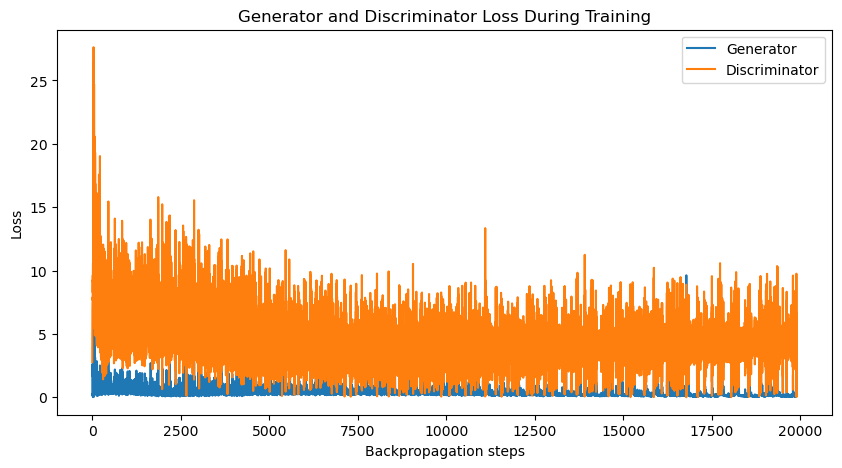

In [33]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("Backpropagation steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

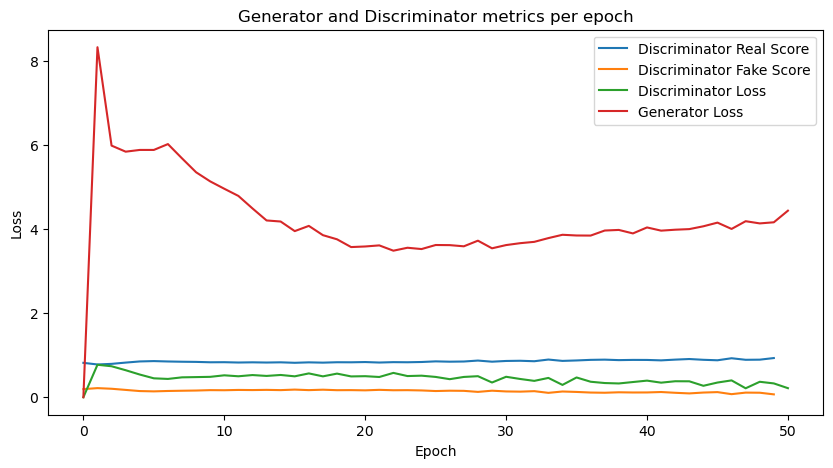

In [34]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator metrics per epoch")
plt.plot(results["d_real_score"], label="Discriminator Real Score")
plt.plot(results["d_fake_score"], label="Discriminator Fake Score")
plt.plot(results["loss_d"], label="Discriminator Loss")
plt.plot(results["loss_g"], label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

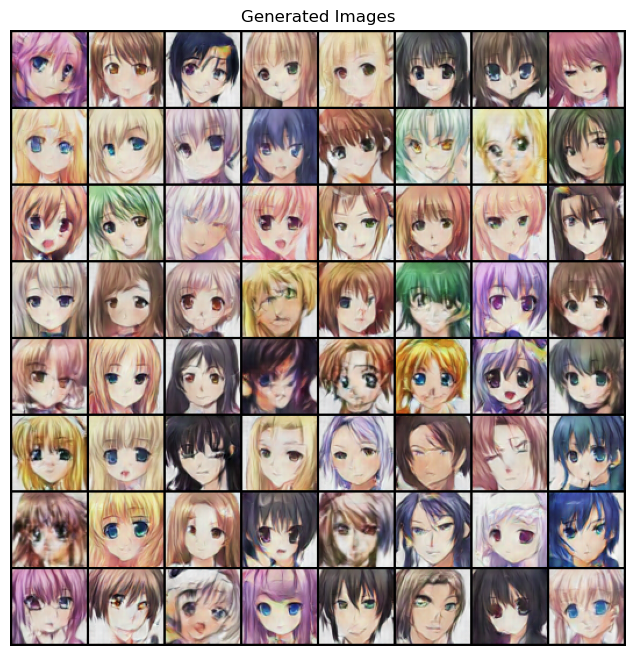

In [35]:
#@title Inference
generator.eval()

with torch.no_grad():
  random_noise = torch.randn(64, latent_size, 1, 1, device=device)
  batch = generator(random_noise)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1,2,0)))

In [36]:
try:
  os.mkdir(f"./models/")
except FileExistsError:
  pass

torch.save(generator.state_dict(), f"./models/generator_{steps}.pth")
torch.save(discriminator.state_dict(), f"./models/discriminator_{steps}.pth")

In [37]:
from torchmetrics.image.fid import FrechetInceptionDistance

In [38]:
fid = FrechetInceptionDistance(reset_real_features=True, normalize=True).to(device)
train_batch = next(iter(training_loader)).to(device)

for batch in tqdm(training_loader):
    fid.update(train_batch, real=True)

with torch.no_grad():
  for _ in range(100):
    random_noise = torch.randn(64, latent_size, 1, 1, device=device)
    batch = generator(random_noise)
    fid.update(batch, real=False)
    
print(fid.compute())

tensor(121.4844, device='cuda:0')
